# Quora Question Pairs

## Quck view on the data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

In [2]:
print('# File sizes')
for f in os.listdir('input'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('input/' + f) / 1000000, 2)) + 'MB')

# File sizes
sample_submission.csv         22.35MB
test.csv                      314.02MB
train.csv                     63.4MB


In [2]:
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")

In [4]:
print(df_train.shape)
print(df_test.shape)

(404290, 6)
(2345796, 3)


In [5]:
df_train.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


In [6]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [7]:
df_train[df_train["qid1"] == 18840]

,id,qid1,qid2,question1,question2,is_duplicate
9701,9701,18840,18841,Do you believe there is life after death?,Do you believe in life after death?,1
15933,15933,18840,30400,Do you believe there is life after death?,Do you believe there is death after life?,0
72711,72711,18840,124883,Do you believe there is life after death?,How would life be after death?,1
90262,90262,18840,49658,Do you believe there is life after death?,What does life after death look like?,1
119781,119781,18840,88678,Do you believe there is life after death?,What are the theories as to what happens after...,1
190902,190902,18840,113929,Do you believe there is life after death?,"If there is life after death, why do I live?",1
232572,232572,18840,59735,Do you believe there is life after death?,Can we ever know if there is life after death?,1
262681,262681,18840,133237,Do you believe there is life after death?,Is there life after death?,1
269565,269565,18840,75205,Do you believe there is life after death?,Is there life after death? Can we revive our l...,1
364460,364460,18840,92133,Do you believe there is life after death?,What is the life after death.?,1


In [160]:
df_train[df_train["id"] == 38675]

,id,qid1,qid2,question1,question2,is_duplicate
38675,38675,70206,70207,Do banks in Dubai offer credit cards on an AED...,Do banks in Dubai offer credit cards on an AED...,0


## Preprocess data

In [4]:
qs_train = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
qs_test = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

print(type(qs_train))
qs_train.head()

<class 'pandas.core.series.Series'>


0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

## Feature Analysis

In [7]:
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

from nltk.stem.porter import PorterStemmer

from nltk.corpus import stopwords

#nltk.download("stopwords")
#nltk.download("averaged_perceptron_tagger")
#nltk.download("punkt")
#nltk.download("maxent_treebank_pos_tagger")
#nltk.download("porter_test")

### Word Match

In [32]:
# Lemmatization
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    res = []
    lemmatizer = WordNetLemmatizer()
    for word, pos in pos_tag(word_tokenize(sentence)):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        res.append(lemmatizer.lemmatize(word, pos=wordnet_pos))
    return res


# Stem words
def stem_words(sentence):
    porter_stemmer = PorterStemmer()
    
    # If sentence is a string, transfer to array
    if type(sentence) == str:
        sentence = sentence.split()
    
    st_lst = []
    for w in sentence:
        w = porter_stemmer.stem(w)
        st_lst.append(w)
    
    return st_lst
    


# Remove stopwords
stops = set(stopwords.words('english'))

def remove_stopwords(sentence):
    # Input a str or list type sentence, remove the stopwords
    # Return a word list
    
    # If sentence is a string, transfer to array
    if type(sentence) == str:
        sentence = sentence.split()
    
    # return type is list
#     ns_lst = []
#     for w in sentence:
#         if w not in stops:
#             ns_lst.append(w)

    # return type is dict
    ns_words = {}
    for word in sentence:
        if word not in stops:
            ns_words[word] = 1

    return ns_words
            

# Word matching
def word_match_share(row):
    # Input a row of question pairs 
    # Return (comm_word_cnt_q1 + comm_word_cnt_q2)/(word_cnt_q1 + word_cnt_q2)
    
    q1 = str(row['question1']).lower()
    q2 = str(row['question2']).lower()
    
    # Lemmatize
    #q1 = lemmatize_sentence(q1)
    #q2 = lemmatize_sentence(q2)
    
    # Remove stopwords
    q1_words = remove_stopwords(q1)
    q2_words = remove_stopwords(q2)
    
    # Stemming
    #q1_words = stem_words(q1_words)
    #q2_words = stem_words(q2_words)
    
    if len(q1_words) == 0 or len(q2_words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_words_in_q1 = [w for w in q1_words if w in q2_words]
    shared_words_in_q2 = [w for w in q2_words if w in q1_words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1_words) + len(q2_words))
    return R

# Uni test
#uni_train = df_train[0:5]
#word_match_train = uni_train.apply(word_match_share, axis=1, raw=True)
#word_match_train

word_match_train = df_train.apply(word_match_share, axis=1, raw=True)
        

### TF-INF

In [9]:
from collections import Counter

In [38]:
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(qs_train)).lower().split()
# counts is the dict format and count for the word in all questions
counts = Counter(words)
# weights is 1/(count+5000)
weights = {word: get_weight(count) for word, count in counts.items()}


In [39]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    # shared_weights: q1 shared words' weight + q2 shared words' weight
    # total_weights: q1 all words' weight + q2 all words' weight
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] 
                        + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R


tfidf_word_match_train = df_train.apply(tfidf_word_match_share, axis=1, raw=True)



/Users/jon/anaconda/envs/ML3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


### Fuzzy Wuzzy

In [120]:
from fuzzywuzzy import fuzz

In [122]:
print("Start to calculate fuzzy features.")

fuzz_qratio = df_train.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
print("1/7 QRatio finished.")

fuzz_wratio = df_train.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
print("2/7 WRatio finished.")

fuzz_partial_ratio = df_train.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
print("3/7 Partial Ratio finished.")

fuzz_partial_token_set_ratio = df_train.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
print("4/7 Partial Token Set Ratio finished.")

fuzz_partial_token_sort_ratio = df_train.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
print("5/7 Partial Token Sort Ratio finished.")

fuzz_token_set_ratio = df_train.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
print("6/7 Token Set Ratio finished.")

fuzz_token_sort_ratio = df_train.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
print("7/7 Token Sort Ratio finished.")

Start to calculate fuzzy features.
1/7 QRatio finished.
2/7 WRatio finished.
3/7 Partial Ratio finished.
4/7 Partial Token Set Ratio finished.
5/7 Partial Token Sort Ratio finished.
6/7 Token Set Ratio finished.
7/7 Token Sort Ratio finished.


### Word2Vec (GoogleNews-vectors-negative300.bin.gz)

In [16]:
import gensim
from tqdm import tqdm
#import pyemd
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

In [8]:
def wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return model.wmdistance(s1, s2)

def norm_wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return norm_model.wmdistance(s1, s2)

In [6]:
model = gensim.models.KeyedVectors.load_word2vec_format('input/GoogleNews-vectors-negative300.bin.gz', binary=True)
print("Model built.")
wmd_train = df_train.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)
print("Word Mover Distince finished.")


norm_model = gensim.models.KeyedVectors.load_word2vec_format('input/GoogleNews-vectors-negative300.bin.gz', binary=True)
norm_model.init_sims(replace=True)
print("Normalize model built.")
norm_wmd_train = df_train.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)
print("Normalize Word Mover Distince finished.")

Model built.
Word Mover Distince finished.
Normalize model built.
Normalize Word Mover Distince finished.


In [9]:
def sent2vec(s):
    #words = str(s).lower().decode('utf-8')
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

stop_words = stopwords.words('english')

In [46]:
question1_vectors = np.zeros((df_train.shape[0], 300))
error_count = 0

for i, q in tqdm(enumerate(df_train.question1.values)):
    question1_vectors[i, :] = sent2vec(q)

question2_vectors  = np.zeros((df_train.shape[0], 300))
for i, q in tqdm(enumerate(df_train.question2.values)):
    question2_vectors[i, :] = sent2vec(q)


209it [00:00, 553.37it/s]/Users/jon/anaconda/envs/ML3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars
404290it [01:51, 3610.34it/s]
404290it [01:56, 3476.52it/s]


In [49]:
cosine_distance = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
print("1/11 Cosine Distance finished.")
cityblock_distance = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
print("2/11 Cityblock Distance finished.")
jaccard_distance = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
print("3/11 Jaccard Distance finished.")
canberra_distance = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
print("4/11 Canberra Distance finished.")
euclidean_distance = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
print("5/11 Euclidean Distance finished.")
minkowski_distance = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
print("6/11 Minkowski Distance finished.")
braycurtis_distance = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
print("7/11 Braycurtis Distance finished.")
skew_q1vec = [skew(x) for x in np.nan_to_num(question1_vectors)]
print("8/11 Skew Q1 Vec finished.")
skew_q2vec = [skew(x) for x in np.nan_to_num(question2_vectors)]
print("9/11 Skew Q2 Vec finished.")
kur_q1vec = [kurtosis(x) for x in np.nan_to_num(question1_vectors)]
print("10/11 Kurtosis Q1 Vec finished.")
kur_q2vec = [kurtosis(x) for x in np.nan_to_num(question2_vectors)]
print("11/11 Kurtosis Q2 Vec finished.")

/Users/jon/anaconda/envs/ML3/lib/python3.6/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


1/11 Cosine Distance finished.
2/11 Cityblock Distance finished.


/Users/jon/anaconda/envs/ML3/lib/python3.6/site-packages/scipy/spatial/distance.py:616: RuntimeWarning: invalid value encountered in double_scalars
  np.double(np.bitwise_or(u != 0, v != 0).sum()))


3/11 Jaccard Distance finished.
4/11 Canberra Distance finished.
5/11 Euclidean Distance finished.
6/11 Minkowski Distance finished.


/Users/jon/anaconda/envs/ML3/lib/python3.6/site-packages/scipy/spatial/distance.py:810: RuntimeWarning: invalid value encountered in double_scalars
  return abs(u - v).sum() / abs(u + v).sum()


7/11 Braycurtis Distance finished.
8/11 Skew Q1 Vec finished.
9/11 Skew Q2 Vec finished.
10/11 Kurtosis Q1 Vec finished.
11/11 Kurtosis Q2 Vec finished.


### Generate Features

In [187]:
# First we create our training and testing data
# To distinct with the rebalance x_train, use another name. 
# All train data without rebalance data and split validation set.
x_all_train = pd.DataFrame()
x_all_train['word_match'] = word_match_train
x_all_train['tfidf_word_match'] = tfidf_word_match_train

x_all_train['fuzz_qratio'] = fuzz_qratio
x_all_train['fuzz_wratio'] = fuzz_wratio
x_all_train['fuzz_partial_ratio'] = fuzz_partial_ratio
x_all_train['fuzz_partial_token_set_ratio'] = fuzz_partial_token_set_ratio 
x_all_train['fuzz_partial_token_sort_ratio'] = fuzz_partial_token_sort_ratio
x_all_train['fuzz_token_set_ratio'] = fuzz_token_set_ratio
x_all_train['fuzz_token_sort_ratio'] = fuzz_token_sort_ratio

x_all_train['wmd'] = wmd_train
x_all_train['norm_wmd'] = norm_wmd_train

x_all_train['cosine_distance'] = cosine_distance                   
x_all_train['cityblock_distance'] = cityblock_distance                         
x_all_train['jaccard_distance'] = jaccard_distance                           
x_all_train['canberra_distance'] = canberra_distance                          
x_all_train['euclidean_distance'] = euclidean_distance                          
x_all_train['minkowski_distance'] = minkowski_distance                        
x_all_train['braycurtis_distance'] = braycurtis_distance
x_all_train['skew_q1vec'] = skew_q1vec
x_all_train['skew_q2vec'] = skew_q2vec
x_all_train['kur_q1vec'] = kur_q1vec
x_all_train['kur_q2vec'] = kur_q2vec

In [28]:
y_all_train = df_train["is_duplicate"]

### Basic Ones

In [189]:
x_all_train['len_q1'] = df_train.question1.apply(lambda x: len(str(x)))
x_all_train['len_q2'] = df_train.question2.apply(lambda x: len(str(x)))
x_all_train['diff_len'] = x_all_train.len_q1 - x_all_train.len_q2
x_all_train['len_char_q1'] = df_train.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
x_all_train['len_char_q2'] = df_train.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
x_all_train['len_word_q1'] = df_train.question1.apply(lambda x: len(str(x).split()))
x_all_train['len_word_q2'] = df_train.question2.apply(lambda x: len(str(x).split()))

print("Basic features generation finished.")

Basic features generation finished.


### Save and Load

In [51]:
x_all_train.to_pickle("pickle/x_all_train_wm_twm_fz_wmd_nwmd_w2v_bs.pkl")
#y_train.to_pickle("pickle/y_train.pkl")

#x_all_train = pd.read_pickle("pickle/x_all_train_wm_twm_fz_wmd_nwmd_w2v_bs.pkl")
#y_train = pd.read_pickle("pickle/y_train.pkl")

In [52]:
x_all_train.head()

,word_match,tfidf_word_match,fuzz_qratio,fuzz_wratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,len_q1,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,0.727273,0.772164,93,95,98,100,88,100,93,66,...,5.081614,1.0,94.023324,0.371408,0.168999,0.186557,0.031817,-0.091902,0.050416,0.337301
1,0.307692,0.361758,66,86,73,100,73,86,63,51,...,14.195119,1.0,177.588090,1.012091,0.455910,0.592655,0.008735,0.094704,0.284010,-0.034444
2,0.363636,0.355191,43,60,41,100,71,63,63,73,...,9.055989,1.0,135.988707,0.666346,0.307828,0.342306,0.239752,0.144554,0.026759,-0.474131
3,0.000000,0.000000,9,27,20,32,30,28,24,50,...,15.987437,1.0,192.237828,1.140536,0.506028,0.692421,-0.002527,0.069649,-0.244560,-0.265568
4,0.000000,0.000000,35,86,54,100,67,67,47,76,...,12.103178,1.0,161.408435,0.860225,0.382770,0.480633,-0.133849,0.114777,0.217900,-0.338876


### Rebalance data

In [53]:
pos_train = x_all_train[y_all_train == 1]
neg_train = x_all_train[y_all_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_rb_train = pd.concat([pos_train, neg_train])
y_rb_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


## Train by XGBoost

In [15]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [54]:
# Split training set and validation set
x_train, x_valid, y_train, y_valid = train_test_split(x_rb_train, y_rb_train, test_size=0.2, random_state=1234)

In [55]:
x_train.head()
#x_train = x_train['tfidf_word_match']
#print(x_train.shape)
#y_train

,word_match,tfidf_word_match,fuzz_qratio,fuzz_wratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,len_q1,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
289607,0.545455,0.564167,40,86,58,100,63,78,39,31,...,7.800209,1.0,137.943319,0.560420,0.250547,0.307790,-0.259497,-0.216799,0.225005,0.431887
87205,0.210526,0.243340,43,63,45,100,48,66,48,103,...,12.582950,1.0,162.423454,0.918086,0.416813,0.506465,0.290964,-0.077883,0.039805,-0.012489
240151,0.000000,0.000000,10,17,33,32,32,18,18,56,...,16.626272,1.0,195.608547,1.211239,0.552372,0.742914,0.006145,0.311841,-0.314150,0.070910
270656,0.272727,0.303430,38,86,47,100,51,69,50,156,...,7.968383,1.0,135.096929,0.568729,0.253773,0.307257,0.054379,-0.085033,0.045566,-0.047354
329996,0.000000,0.000000,79,86,88,100,100,100,79,16,...,7.640873,1.0,127.142617,0.555328,0.253177,0.286035,-0.171085,-0.117687,-0.353976,0.070035


In [56]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

num_round = 500
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

parm = {}
parm['max_depth'] = 4
parm['eta'] = 0.03 #learning_rate
parm['objective'] = 'binary:logistic'
parm['eval_metric'] = 'logloss'
#parm["subsample"] = 0.7
#parm["colsample_bytree"] = 0.7

bst = xgb.train(parm, d_train, num_round, watchlist, early_stopping_rounds=50, verbose_eval=20)


[0]	train-logloss:0.677938	valid-logloss:0.677964
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[20]	train-logloss:0.496201	valid-logloss:0.4966
[40]	train-logloss:0.422071	valid-logloss:0.42274
[60]	train-logloss:0.38699	valid-logloss:0.387816
[80]	train-logloss:0.369087	valid-logloss:0.370054
[100]	train-logloss:0.359524	valid-logloss:0.360587
[120]	train-logloss:0.354423	valid-logloss:0.355586
[140]	train-logloss:0.351289	valid-logloss:0.352514
[160]	train-logloss:0.349126	valid-logloss:0.350393
[180]	train-logloss:0.347604	valid-logloss:0.348917
[200]	train-logloss:0.346214	valid-logloss:0.347569
[220]	train-logloss:0.344797	valid-logloss:0.346226
[240]	train-logloss:0.343301	valid-logloss:0.344788
[260]	train-logloss:0.342005	valid-logloss:0.343523
[280]	train-logloss:0.340931	valid-logloss:0.342502
[300]	train-logloss:0.339778	valid-logloss:0.341423
[320]	train-logloss:0.33867

In [172]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], word_match_train))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_word_match_train.fillna(0)))
print(' difflib AUC:', roc_auc_score(df_train['is_duplicate'], diff_seq_match_train))

Original AUC: 0.780553200628
   TFIDF AUC: 0.77056466105
 difflib AUC: 0.731927259142


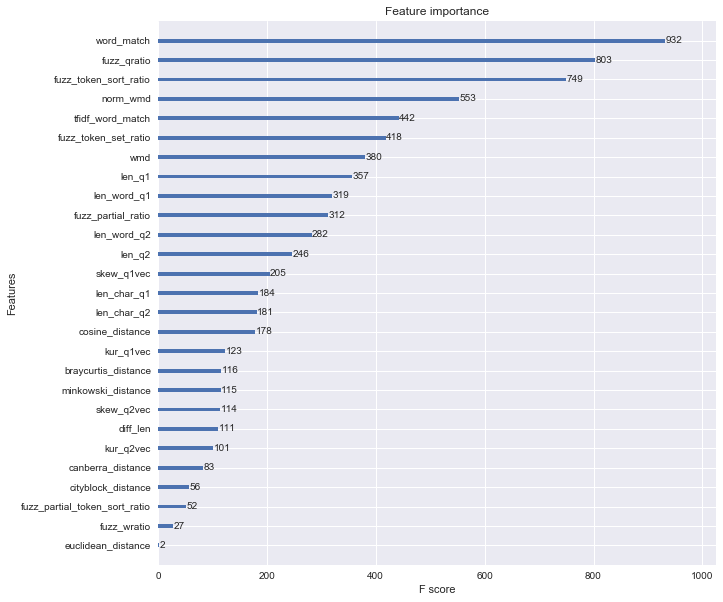

In [57]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
xgb.plot_importance(bst); plt.show()

## Predict for submission

### Generate features for test data

In [17]:
# Generate test features

# #Word match and TFIDF word match
# x_test = pd.DataFrame()
# x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
# x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)
# x_test['diff_seq_match'] = df_test.apply(diff_seq_matcher, axis=1, raw=True)

# #Fuzzywuzzy
# x_test['fuzz_qratio'] = df_test.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
# print("1/7 QRatio finished.")
# x_test['fuzz_wratio'] = df_test.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
# print("2/7 WRatio finished.")
# x_test['fuzz_partial_ratio'] = df_test.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
# print("3/7 Partial Ratio finished.")
# x_test['fuzz_partial_token_set_ratio'] = df_test.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
# print("4/7 Partial Token Set Ratio finished.")
# x_test['fuzz_partial_token_sort_ratio'] = df_test.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
# print("5/7 Partial Token Sort Ratio finished.")
# x_test['fuzz_token_set_ratio'] = df_test.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
# print("6/7 Token Set Ratio finished.")
# x_test['fuzz_token_sort_ratio'] = df_test.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
# print("7/7 Token Sort Ratio finished.")

# #Basic ones
# x_test['len_q1'] = df_test.question1.apply(lambda x: len(str(x)))
# x_test['len_q2'] = df_test.question2.apply(lambda x: len(str(x)))
# x_test['diff_len'] = x_test.len_q1 - x_test.len_q2
# x_test['len_char_q1'] = df_test.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
# x_test['len_char_q2'] = df_test.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
# x_test['len_word_q1'] = df_test.question1.apply(lambda x: len(str(x).split()))
# x_test['len_word_q2'] = df_test.question2.apply(lambda x: len(str(x).split()))


# #Word2Vec
# x_test['wmd'] = df_test.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)
# print("Word Mover Distince finished.")
# x_test['norm_wmd'] = df_test.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)
# print("Normalize Word Mover Distince finished.")

question1_vectors_test = np.zeros((df_test.shape[0], 300))
error_count_test = 0

for i, q in tqdm(enumerate(df_test.question1.values)):
    question1_vectors_test[i, :] = sent2vec(q)
print("Q1 sent2vec finished.")

question2_vectors_test  = np.zeros((df_test.shape[0], 300))
for i, q in tqdm(enumerate(df_test.question2.values)):
    question2_vectors_test[i, :] = sent2vec(q)
print("Q2 sent2vec finished.")
    
x_test['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors_test), np.nan_to_num(question2_vectors_test))]
print("1/11 Cosine Distance finished.")
x_test['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors_test), np.nan_to_num(question2_vectors_test))]
print("2/11 Cityblock Distance finished.")
x_test['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors_test), np.nan_to_num(question2_vectors_test))]
print("3/11 Jaccard Distance finished.")
x_test['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors_test), np.nan_to_num(question2_vectors_test))]
print("4/11 Canberra Distance finished.")
x_test['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors_test), np.nan_to_num(question2_vectors_test))]
print("5/11 Euclidean Distance finished.")
x_test['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors_test), np.nan_to_num(question2_vectors_test))]
print("6/11 Minkowski Distance finished.")
x_test['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors_test), np.nan_to_num(question2_vectors_test))]
print("7/11 Braycurtis Distance finished.")
x_test['skew_q1vec'] = [skew(x) for x in np.nan_to_num(question1_vectors_test)]
print("8/11 Skew Q1 Vec finished.")
x_test['skew_q2vec'] = [skew(x) for x in np.nan_to_num(question2_vectors_test)]
print("9/11 Skew Q2 Vec finished.")
x_test['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors_test)]
print("10/11 Kurtosis Q1 Vec finished.")
x_test['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors_test)]
print("11/11 Kurtosis Q2 Vec finished.")


0it [00:00, ?it/s]/Users/jon/anaconda/envs/ML3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars

362it [00:00, 3619.49it/s]
858it [00:00, 3936.17it/s]
1189it [00:00, 3723.30it/s]
1674it [00:00, 4000.89it/s]
1999it [00:00, 3530.35it/s]
2313it [00:00, 3402.20it/s]
2625it [00:00, 3301.62it/s]
2938it [00:00, 3246.87it/s]
3280it [00:00, 3296.75it/s]
3609it [00:01, 3294.32it/s]
4038it [00:01, 3538.61it/s]
4393it [00:01, 3435.66it/s]
4760it [00:01, 3501.39it/s]
5112it [00:01, 3396.58it/s]
5454it [00:01, 3333.28it/s]
5824it [00:01, 3435.31it/s]
6175it [00:01, 3457.04it/s]
6522it [00:01, 3441.77it/s]
6903it [00:01, 3542.53it/s]
7259it [00:02, 3265.02it/s]
7620it [00:02, 3361.35it/s]
7961it [00:02, 3367.44it/s]
8301it [00:02, 3364.27it/s]
8661it [00:02, 3431.05it/s]
9006it [00:02, 3362.86it/s]
9344it [00:02, 3328.71it/s]
9719it [00:02, 3442.88it/s]
10106it [00:02, 3559.53it/s]
10499it [00:02, 3661.25it/s]
10868it [00:03, 3514.73it

Q1 sent2vec finished.


2345796it [10:27, 3735.68it/s]


Q2 sent2vec finished.


/Users/jon/anaconda/envs/ML3/lib/python3.6/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


1/11 Cosine Distance finished.
2/11 Cityblock Distance finished.


/Users/jon/anaconda/envs/ML3/lib/python3.6/site-packages/scipy/spatial/distance.py:616: RuntimeWarning: invalid value encountered in double_scalars
  np.double(np.bitwise_or(u != 0, v != 0).sum()))


3/11 Jaccard Distance finished.
4/11 Canberra Distance finished.
5/11 Euclidean Distance finished.
6/11 Minkowski Distance finished.


/Users/jon/anaconda/envs/ML3/lib/python3.6/site-packages/scipy/spatial/distance.py:810: RuntimeWarning: invalid value encountered in double_scalars
  return abs(u - v).sum() / abs(u + v).sum()


7/11 Braycurtis Distance finished.
8/11 Skew Q1 Vec finished.
9/11 Skew Q2 Vec finished.
10/11 Kurtosis Q1 Vec finished.
11/11 Kurtosis Q2 Vec finished.


In [18]:
x_test.head()

,word_match,tfidf_word_match,fuzz_qratio,fuzz_wratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,len_q1,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,0.266667,0.274019,37,51,48,100,56,54,50,57,...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,-3.0,-3.0
1,0.500000,0.480962,47,86,53,100,64,82,58,66,...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,-3.0,-3.0
2,0.444444,0.468893,57,86,76,100,68,92,55,60,...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,-3.0,-3.0
3,0.000000,0.000000,52,53,53,62,62,52,52,27,...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,-3.0,-3.0
4,0.800000,1.000000,70,70,69,100,67,74,66,32,...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,-3.0,-3.0


In [19]:
x_test.to_pickle("pickle/x_test_wm_twm_fz_wmd_nwmd_w2v_bs.pkl")

#x_test = pd.read_pickle("pickle/x_test_wm_twm_fz_wmd_nwmd_w2v_bs.pkl")

In [179]:
#del x_test['diff_seq_match']

### Predict and save output

In [35]:
# Predict and save output
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('output/wm_twm_fz_wmd_nwmd_bs_rb_xgb_500_4_003.csv', index=False)
print("Saved csv.")

Saved csv.


ImportError: You must install graphviz to plot tree

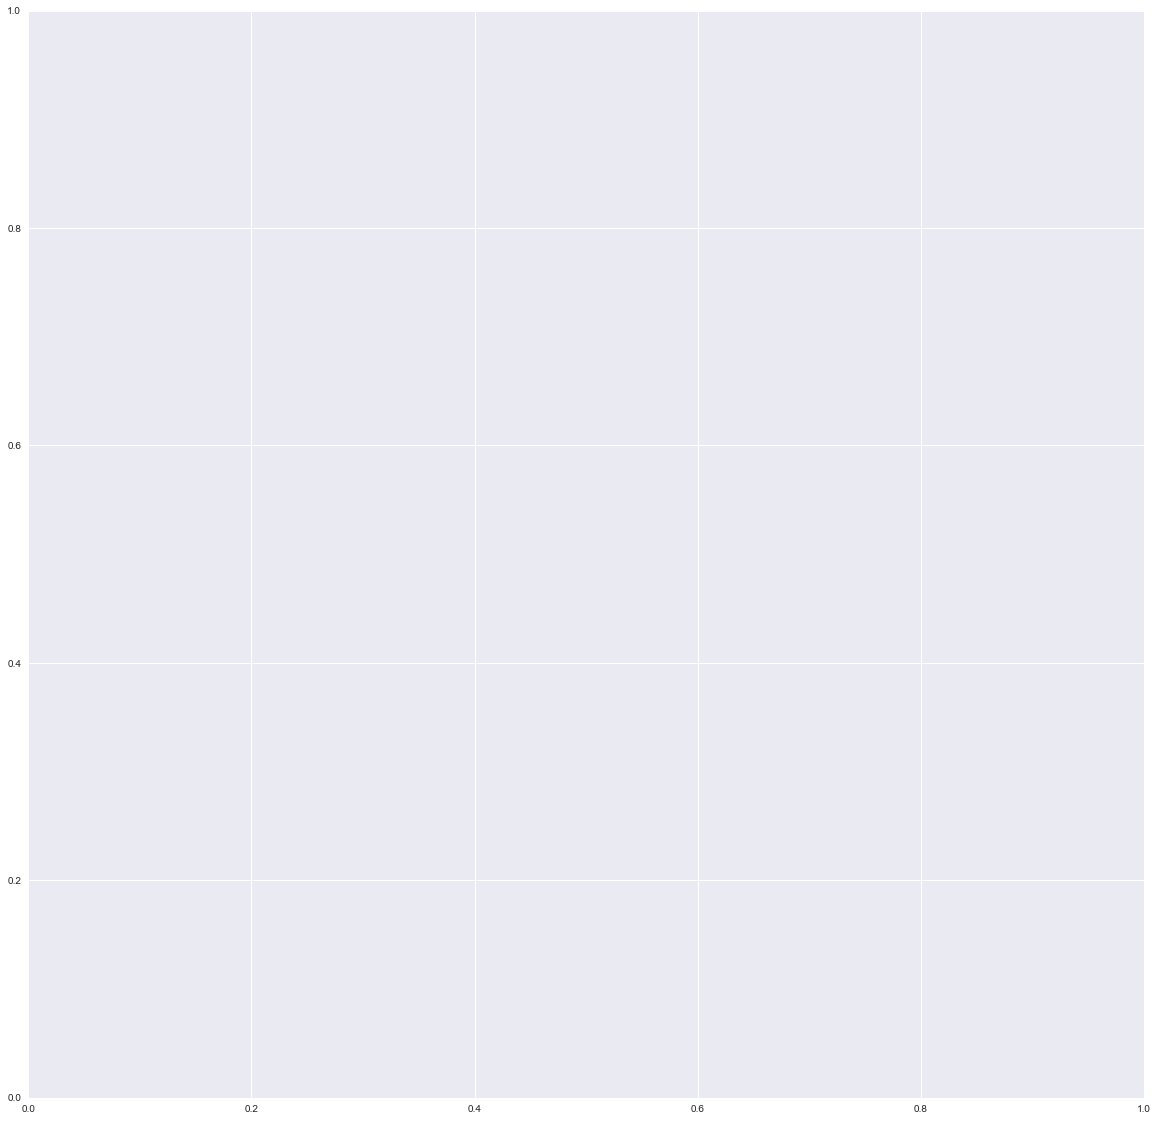

In [181]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
xgb.plot_tree(bst, num_trees=0); plt.show()